In [118]:
# %% Importing the libraries

# upload files
from google.colab import files

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import torchvision
import torchvision.transforms as T
from torchvision.utils import save_image
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25


In [119]:
#%% Import Class & Functions

# from google.colab import drive
# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/Python')

# # CNN Class
# import Class.CNN_AE_0 as CNN_AE
# import Class.CNN as CNN

# # Function
# from Function.dSplit import dSplit
# import Function.LossFunc as LF
# import Function.myDataset as mD


In [120]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

Import Images

In [121]:
#%% Import image
# img_content_file = files.upload()
# img_content_filename = next(iter(img_content_file))
dl_img_content = imread(img_content_filename)

img_style_file = files.upload()
img_style_filename = next(iter(img_style_file))
dl_img_style = imread(img_style_filename)

# init the target image
img_target = np.random.randint(low=0, high=255, size=dl_img_content.shape, dtype=np.uint8)

# check shape
print(dl_img_content.shape)
print(dl_img_style.shape)
print(img_target.shape)


Saving H4063-L70976430.jpg to H4063-L70976430.jpg
(2268, 4032, 3)
(505, 750, 3)
(2268, 4032, 3)


Text(0.5, 1.0, 'Init Target')

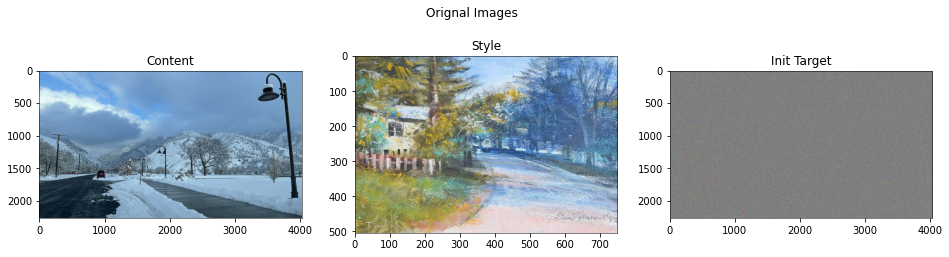

In [122]:
#%% plot images

# create a figure
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Orignal Images')

# content
axs[0].imshow(dl_img_content)
axs[0].set_title('Content')

# style
axs[1].imshow(dl_img_style)
axs[1].set_title('Style')

# target
axs[2].imshow(img_target)
axs[2].set_title('Init Target')


In [123]:
#%% Transformations
transform = T.Compose([ 
                        T.ToTensor(), # normalizes to range [0,1]   
                        T.Resize(256), # resize to fit the net
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization with recommended values
                        # T.RandomHorizontalFlip(p=.5),
                        # T.Normalize(0.5, 0.5),
                        # T.ToPILImage(),
                        # T.RandomVerticalFlip(p=.5),
                        # T.RandomRotation(90),        
                       ])

# apply the transform and send to deivce
img_content = transform(dl_img_content).unsqueeze(0).to(device)
img_style = transform(dl_img_style).unsqueeze(0).to(device)
img_target = transform(img_target).unsqueeze(0).to(device)

# add dimension
# img_content = img_content[None, :, :, :]
# img_style = img_style[None, :, :, :]
# img_target = img_target[None, :, :, :]

# check shape
print(img_content.shape)
print(img_style.shape)
print(img_target.shape)


torch.Size([1, 3, 256, 455])
torch.Size([1, 3, 256, 380])
torch.Size([1, 3, 256, 455])


Text(0.5, 1.0, 'Init Target')

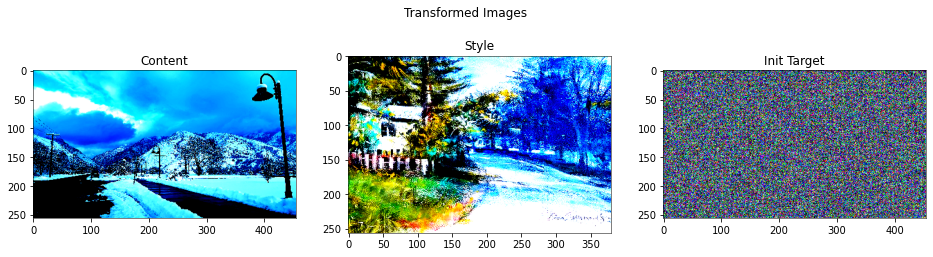

In [124]:
#%% plot images

# create a figure
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Transformed Images')

# content
img = img_content[0].permute(1, 2, 0).cpu()
axs[0].imshow(img)
axs[0].set_title('Content')

# style
img = img_style[0].permute(1, 2, 0).cpu()
axs[1].imshow(img)
axs[1].set_title('Style')

# target
img = img_target[0].permute(1, 2, 0).cpu()
axs[2].imshow(img)
axs[2].set_title('Init Target')


Text(0.5, 1.0, 'Init Target')

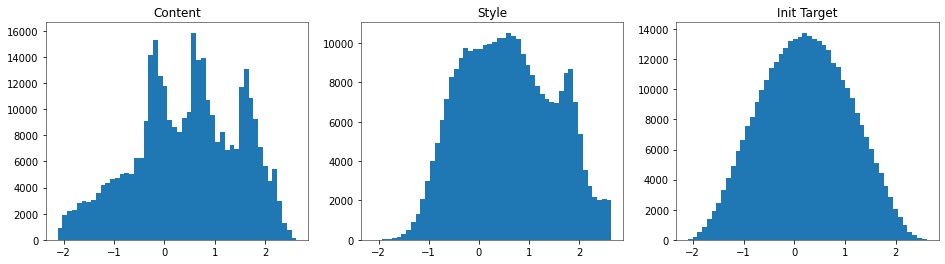

In [125]:
# check value in the img

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# plot hist
x = img_content.cpu().view(-1, 1).detach().numpy()
axs[0].hist(x, 50)
axs[0].set_title('Content')

# plot hist
x = img_style.cpu().view(-1, 1).detach().numpy()
axs[1].hist(x, 50)
axs[1].set_title('Style')

# plot hist
x = img_target.cpu().view(-1, 1).detach().numpy()
axs[2].hist(x, 50)
axs[2].set_title('Init Target')


Import Model

In [126]:
# Import net
net = torchvision.models.alexnet(weights=True)
summary(net.to(device), (3, 96, 96))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 23, 23]          23,296
              ReLU-2           [-1, 64, 23, 23]               0
         MaxPool2d-3           [-1, 64, 11, 11]               0
            Conv2d-4          [-1, 192, 11, 11]         307,392
              ReLU-5          [-1, 192, 11, 11]               0
         MaxPool2d-6            [-1, 192, 5, 5]               0
            Conv2d-7            [-1, 384, 5, 5]         663,936
              ReLU-8            [-1, 384, 5, 5]               0
            Conv2d-9            [-1, 256, 5, 5]         884,992
             ReLU-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]         590,080
             ReLU-12            [-1, 256, 5, 5]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-14            [-1, 25

In [127]:
#%% Freeze all the layers
for p in net.named_parameters():
  p[1].requires_grad = False
  print(f'{p[0]}:requires_grad = {p[1].requires_grad}')

# switch to eval mode
net.eval();

# send to GPU
net.to(device);

features.0.weight:requires_grad = False
features.0.bias:requires_grad = False
features.3.weight:requires_grad = False
features.3.bias:requires_grad = False
features.6.weight:requires_grad = False
features.6.bias:requires_grad = False
features.8.weight:requires_grad = False
features.8.bias:requires_grad = False
features.10.weight:requires_grad = False
features.10.bias:requires_grad = False
classifier.1.weight:requires_grad = False
classifier.1.bias:requires_grad = False
classifier.4.weight:requires_grad = False
classifier.4.bias:requires_grad = False
classifier.6.weight:requires_grad = False
classifier.6.bias:requires_grad = False


In [128]:
# check layer structure
net


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [129]:
# check convolution layer structure
net.features


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Functions

In [130]:
# push image function

def getFeatmap(net, img_in):

  # init vars
  featMap = []
  featMapName = []
  count = 0

  for i in range(len(net.features)):
    # push input image through every layer
    img_in = net.features[i](img_in)

    # store result each convolution layer
    if 'Conv2d' in str(net.features[i]):
      featMap.append(img_in)
      featMapName.append(f'{str(net.features[i])[:6]}_{count}')
      count += 1

  return featMap, featMapName, count


In [131]:
# compute gram matrix

def gramMatrix(featMap):

  _, C, H, W = featMap.shape # chanel, height, width
  # reshape to 2D
  featMap = featMap.reshape(C, H*W)

  # compute covariance matrix
  gram_mat = torch.mm(featMap, featMap.t()) / featMap.numel()

  return gram_mat


Content Image

In [132]:
# compute the feature maps
featMap_content, featMap_content_name, n_conv = getFeatmap(net, img_content)

# check the shape of each conv later
for i in range(n_conv):
  print(f'{featMap_content_name[i]}: {featMap_content[i].shape}')
  

Conv2d_0: torch.Size([1, 64, 63, 113])
Conv2d_1: torch.Size([1, 192, 31, 56])
Conv2d_2: torch.Size([1, 384, 15, 27])
Conv2d_3: torch.Size([1, 256, 15, 27])
Conv2d_4: torch.Size([1, 256, 15, 27])


In [133]:
# mean and normalize the feature maps of each conv layer
featMap_content_norm = []
gram_mat_content_norm = []

for i in range(n_conv):

  # feature maps
  fm_norm = torch.mean(featMap_content[i].cpu().squeeze(), axis=0).detach().numpy()
  fm_norm = (fm_norm - np.min(fm_norm)) / (np.max(fm_norm) - np.min(fm_norm)) # min-max feature scaling
  featMap_content_norm.append(fm_norm)

  # gram matrix
  gm_norm = gramMatrix(featMap_content[i]).cpu().squeeze().detach().numpy()
  gm_norm = (gm_norm - np.min(gm_norm)) / (np.max(gm_norm) - np.min(gm_norm)) # min-max feature scaling
  gram_mat_content_norm.append(gm_norm)

# check the shape
for i in range(n_conv):
  print(f'{featMap_content_name[i]}: featMap:{featMap_content_norm[i].shape}, gram:{gram_mat_content_norm[i].shape}')


Conv2d_0: featMap:(63, 113), gram:(64, 64)
Conv2d_1: featMap:(31, 56), gram:(192, 192)
Conv2d_2: featMap:(15, 27), gram:(384, 384)
Conv2d_3: featMap:(15, 27), gram:(256, 256)
Conv2d_4: featMap:(15, 27), gram:(256, 256)


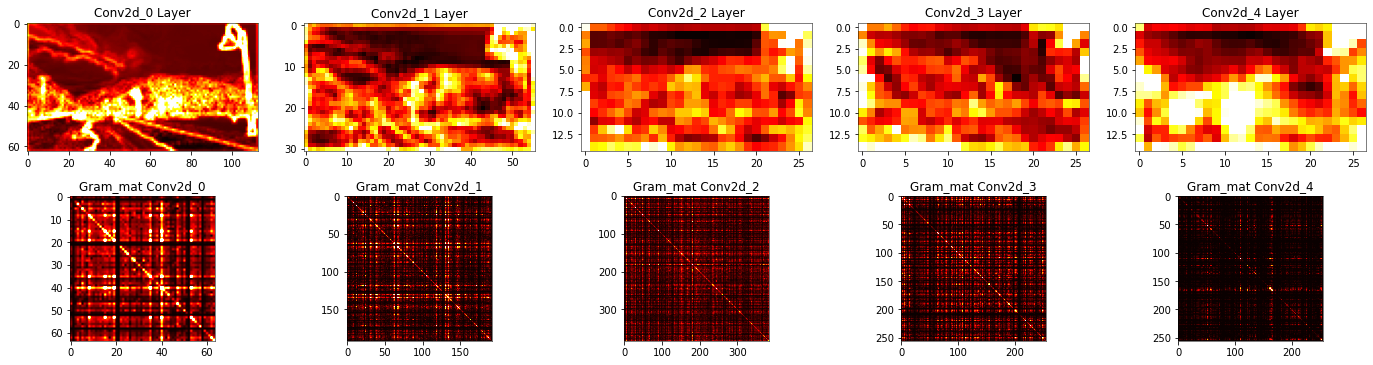

In [134]:
# plot feature maps and gram matrix

img_list = [0, 1, 2, 3, 4]
fig, axs = plt.subplots(2, len(img_list), figsize=(24, 6))

for i, imgi in enumerate(img_list):
  axs[0, i].imshow(featMap_content_norm[imgi], cmap='hot', vmax=0.5)
  axs[0, i].set_title(f'{featMap_content_name[imgi]} Layer')

  axs[1, i].imshow(gram_mat_content_norm[imgi], cmap='hot', vmax=0.1)
  axs[1, i].set_title(f'Gram_mat {featMap_content_name[imgi]}')


Style Image

In [135]:
# compute the feature maps
featMap_style, featMap_style_name, n_conv = getFeatmap(net, img_style)

# check the shape of each conv later
for i in range(n_conv):
  print(f'{featMap_style_name[i]}: {featMap_style[i].shape}')
  

Conv2d_0: torch.Size([1, 64, 63, 94])
Conv2d_1: torch.Size([1, 192, 31, 46])
Conv2d_2: torch.Size([1, 384, 15, 22])
Conv2d_3: torch.Size([1, 256, 15, 22])
Conv2d_4: torch.Size([1, 256, 15, 22])


In [136]:
# mean and normalize the feature maps of each conv layer
featMap_style_norm = []
gram_mat_style_norm = []

for i in range(n_conv):

  # feature maps
  fm_norm = torch.mean(featMap_style[i].cpu().squeeze(), axis=0).detach().numpy()
  fm_norm = (fm_norm - np.min(fm_norm)) / (np.max(fm_norm) - np.min(fm_norm)) # min-max feature scaling
  featMap_style_norm.append(fm_norm)

  # gram matrix
  gm_norm = gramMatrix(featMap_style[i]).cpu().squeeze().detach().numpy()
  gm_norm = (gm_norm - np.min(gm_norm)) / (np.max(gm_norm) - np.min(gm_norm)) # min-max feature scaling
  gram_mat_style_norm.append(gm_norm)

# check the shape
for i in range(n_conv):
  print(f'{featMap_style_name[i]}: featMap:{featMap_style_norm[i].shape}, gram:{gram_mat_style_norm[i].shape}')
  

Conv2d_0: featMap:(63, 94), gram:(64, 64)
Conv2d_1: featMap:(31, 46), gram:(192, 192)
Conv2d_2: featMap:(15, 22), gram:(384, 384)
Conv2d_3: featMap:(15, 22), gram:(256, 256)
Conv2d_4: featMap:(15, 22), gram:(256, 256)


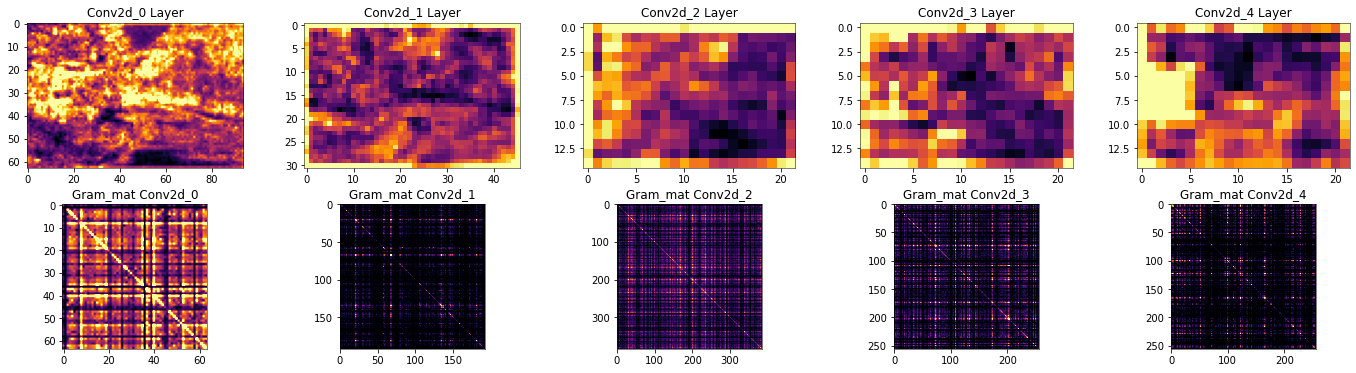

In [137]:
# plot feature maps and gram matrix

img_list = [0, 1, 2, 3, 4]
fig, axs = plt.subplots(2, len(img_list), figsize=(24, 6))

for i, imgi in enumerate(img_list):
  axs[0, i].imshow(featMap_style_norm[imgi], cmap='inferno', vmax=0.5)
  axs[0, i].set_title(f'{featMap_style_name[imgi]} Layer')

  axs[1, i].imshow(gram_mat_style_norm[imgi], cmap='inferno', vmax=0.1)
  axs[1, i].set_title(f'Gram_mat {featMap_style_name[imgi]}')
  

Transfer

In [158]:
# parameters

# layers to use
# content layer
sel_content_layers = np.array([0, 1, 2, 3, 4])
sel_content_layers = [f'Conv2d_{i}' for i in sel_content_layers]

# style layers
sel_style_layers = np.array([0, 1, 2, 3, 4])
sel_style_layers = [f'Conv2d_{i}' for i in sel_style_layers]
weight_style_layers = np.array([1, 1, 0.5, 0.25, 0.1])

# loss style scaling
style_scale = 1e6*1

# make target image trainable
img_target.requires_grad = True

# training metaparams
epochs = 10000
lr = 0.005

# optimizer
optimizer = torch.optim.RMSprop([img_target], lr=lr)

In [159]:
loss_content_list = []
loss_style_list = []
loss_total_list = []

for epochi in range(epochs): 

  # feature map target image
  featMap_target, featMap_target_name, n_conv = getFeatmap(net, img_target)

  # init vars
  loss_content = 0
  loss_style = 0

  # push through layers
  for layeri in range(n_conv):

    # content loss
    if featMap_target_name[layeri] in sel_content_layers:
      loss_content += torch.mean( (featMap_target[layeri]-featMap_content[layeri])**2 )
      loss_content_list.append(loss_content)

    # style loss
    if featMap_style_name[layeri] in sel_style_layers:
      gm_target = gramMatrix(featMap_style[layeri])
      gm_style = gramMatrix(featMap_target[layeri])
      loss_style += torch.mean( (gm_target-gm_style)**2 ) * weight_style_layers[sel_style_layers.index(featMap_style_name[layeri])]
      loss_style_list.append(loss_style)

  # sum loss
  loss_total = loss_content + style_scale*loss_style
  loss_total_list.append(loss_total)

  # backprop
  optimizer.zero_grad()
  loss_total.backward()
  optimizer.step()

  print(f'epoch: {epochi}/{epochs}') if epochi%100==0 else None

epoch: 0/10000
epoch: 100/10000
epoch: 200/10000
epoch: 300/10000
epoch: 400/10000
epoch: 500/10000
epoch: 600/10000
epoch: 700/10000
epoch: 800/10000
epoch: 900/10000
epoch: 1000/10000
epoch: 1100/10000
epoch: 1200/10000
epoch: 1300/10000
epoch: 1400/10000
epoch: 1500/10000
epoch: 1600/10000
epoch: 1700/10000
epoch: 1800/10000
epoch: 1900/10000
epoch: 2000/10000
epoch: 2100/10000
epoch: 2200/10000
epoch: 2300/10000
epoch: 2400/10000
epoch: 2500/10000
epoch: 2600/10000
epoch: 2700/10000
epoch: 2800/10000
epoch: 2900/10000
epoch: 3000/10000
epoch: 3100/10000
epoch: 3200/10000
epoch: 3300/10000
epoch: 3400/10000
epoch: 3500/10000
epoch: 3600/10000
epoch: 3700/10000
epoch: 3800/10000
epoch: 3900/10000
epoch: 4000/10000
epoch: 4100/10000
epoch: 4200/10000
epoch: 4300/10000
epoch: 4400/10000
epoch: 4500/10000
epoch: 4600/10000
epoch: 4700/10000
epoch: 4800/10000
epoch: 4900/10000
epoch: 5000/10000
epoch: 5100/10000
epoch: 5200/10000
epoch: 5300/10000
epoch: 5400/10000
epoch: 5500/10000
epoc

In [160]:
#%% Transformations
tf_end = T.Compose([ 
                    T.Resize(3024), # resize to fit the net    
                    ])

# # apply the transform and apply activation
# res_img_target = tf_end(torch.sigmoid(img_target.cpu()))
res_img_target = torch.sigmoid(img_target.cpu())

Text(0.5, 1.0, 'Transfered Target')

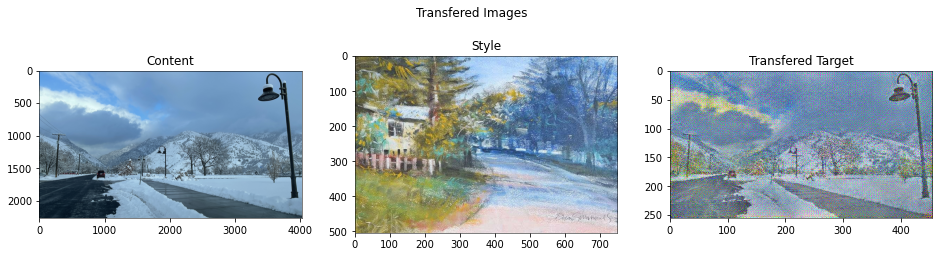

In [161]:
#%% plot images

# create a figure
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Transfered Images')

# content
axs[0].imshow(dl_img_content)
axs[0].set_title('Content')

# style
axs[1].imshow(dl_img_style)
axs[1].set_title('Style')

# target
img = res_img_target[0].detach().permute(1, 2, 0)
axs[2].imshow(img)
axs[2].set_title('Transfered Target')

In [162]:
save_image(res_img_target[0], 'img_target.png')